<a href="https://colab.research.google.com/github/rohmanie55/sentiment_review_lazada_id/blob/master/Submission_Review_Lazada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [206]:
import zipfile,os

!wget --no-check-certificate \
    https://github.com/rohmanie55/sentiment_review_lazada_id/raw/master/dataset/Review.zip \
    -O /tmp/Review.zip

zip = "/tmp/Review.zip"
zip_ref = zipfile.ZipFile(zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

--2020-08-11 02:42:55--  https://github.com/rohmanie55/sentiment_review_lazada_id/raw/master/dataset/Review.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rohmanie55/sentiment_review_lazada_id/master/dataset/Review.zip [following]
--2020-08-11 02:42:56--  https://raw.githubusercontent.com/rohmanie55/sentiment_review_lazada_id/master/dataset/Review.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6253210 (6.0M) [application/zip]
Saving to: ‘/tmp/Review.zip’

/tmp/Review.zip     100%[===================>]   5.96M  20.7MB/s    in 0.3s    

2020-08-11 02:42:56 (20.7 MB/s) - ‘/tmp/Review.zip’ save

In [207]:
import pandas as pd
#masukan dataset ke dataframe
df = pd.read_csv('20191002-reviews.csv')

#buang text kosong
df.dropna(inplace=True)

#masukan dataset ke dataframe
df = pd.read_csv('20191002-reviews.csv')
#buang column yang tidak digunakan
df = df.drop(columns=['itemId', 'category', 'name', 'originalRating',
                      'reviewTitle', 'likeCount', 'upVotes', 'downVotes',
                      'helpful', 'relevanceScore', 'boughtDate', 'clientType', 'retrievedDate'])
#buang data dengan komentar kosong
df.dropna(inplace=True)
#ambil 50000 data
df = df.loc[0:50000]
#pilih 1000 rewiew dari masing masing rating
buruk = df[df.rating.isin([1, 2])].iloc[0:1000]
netral= df[df.rating.isin([3])].iloc[0:1000]
bagus = df[df.rating.isin([4, 5])].iloc[0:1000]
#hapus rating lama
buruk.drop(columns='rating')
netral.drop(columns='rating')
bagus.drop(columns='rating')
#tambahkan rating baru
buruk['rating']='buruk'
netral['rating']='netral'
bagus['rating']='bagus'
#gabungkan review
df_review = pd.concat([buruk, netral, bagus], ignore_index=True, sort=False)

rating = pd.get_dummies(df_review.rating)
df_baru = pd.concat([df_review, rating], axis=1)
df_baru = df_baru.drop(columns='rating')

review = df_baru['reviewContent'].values
rating = df_baru[['buruk', 'netral', 'bagus']].values

In [209]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

review_latih, review_test, label_latih, label_test = train_test_split(review, rating, test_size=0.2, random_state=42)

NB_WORDS = 8000
MAX_LEN = 100
EMBEDDING_DIM = 16

tokenizer = Tokenizer(num_words=NB_WORDS , filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', oov_token="<OOV>", lower=True, char_level=False)
tokenizer.fit_on_texts(review_latih) 

word_index = tokenizer.word_index

sekuens_latih= tokenizer.texts_to_sequences(review_latih)
sekuens_test = tokenizer.texts_to_sequences(review_test)

padded_latih= pad_sequences(sekuens_latih, maxlen=MAX_LEN) 
padded_test = pad_sequences(sekuens_test, maxlen=MAX_LEN)

In [210]:
import tensorflow as tf
from tensorflow.keras import regularizers

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(NB_WORDS , EMBEDDING_DIM, input_length=MAX_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, recurrent_dropout=0.1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_54 (Embedding)     (None, 100, 16)           128000    
_________________________________________________________________
bidirectional_54 (Bidirectio (None, 128)               41472     
_________________________________________________________________
dropout_106 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_135 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_136 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_107 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_137 (Dense)            (None, 3)               

Epoch 1/20
19/19 - 7s - loss: 1.1714 - accuracy: 0.3596 - val_loss: 1.1590 - val_accuracy: 0.3683
Epoch 2/20
19/19 - 6s - loss: 1.1351 - accuracy: 0.4212 - val_loss: 1.1162 - val_accuracy: 0.4417
Epoch 3/20
19/19 - 6s - loss: 1.0683 - accuracy: 0.4771 - val_loss: 1.0397 - val_accuracy: 0.5067
Epoch 4/20
19/19 - 6s - loss: 0.9238 - accuracy: 0.5721 - val_loss: 0.9498 - val_accuracy: 0.5700
Epoch 5/20
19/19 - 6s - loss: 0.7926 - accuracy: 0.6500 - val_loss: 0.9559 - val_accuracy: 0.5767
Epoch 6/20
19/19 - 6s - loss: 0.6997 - accuracy: 0.7083 - val_loss: 1.0019 - val_accuracy: 0.5733
Epoch 7/20
19/19 - 6s - loss: 0.5912 - accuracy: 0.7708 - val_loss: 1.0240 - val_accuracy: 0.5967
Epoch 8/20
19/19 - 6s - loss: 0.5168 - accuracy: 0.8033 - val_loss: 1.0970 - val_accuracy: 0.5633
Epoch 9/20
19/19 - 6s - loss: 0.4807 - accuracy: 0.8375 - val_loss: 1.1917 - val_accuracy: 0.5633
Epoch 10/20
19/19 - 6s - loss: 0.4218 - accuracy: 0.8592 - val_loss: 1.2886 - val_accuracy: 0.5567
Epoch 11/20
19/19 -

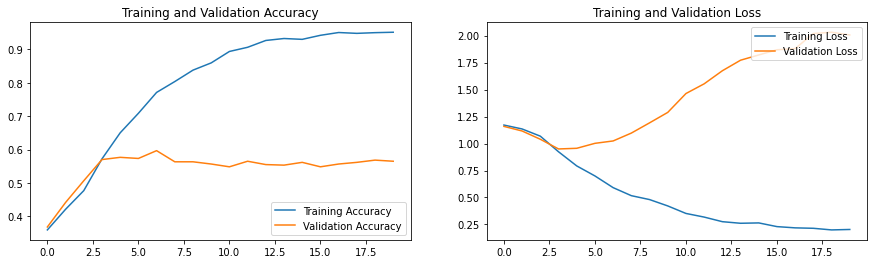

In [200]:
import matplotlib.pyplot as plt

num_epochs = 20
batch_size = 128

history = model.fit(padded_latih, label_latih, epochs=num_epochs, batch_size=batch_size, 
                    validation_data=(padded_test, label_test), verbose=2)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [202]:
import numpy as np

labels = ['buruk', 'netral', 'bagus']
sentence = ["lumayan lah sesuai harga"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=MAX_LEN)
predict= model.predict(padded)
print(labels[np.argmax(predict)])

netral
